In [2]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [3]:
path = 'sonido-presion/'
files = {i: {'presion': [], 'sonido': []} for i in range(1,4)}

for i,file in enumerate(os.listdir(path)):
    file_name = str(os.path.splitext(file)[0])
    segmento = int(file_name.split('_')[2])
    param = file_name.split('_')[0]
    if segmento == 1:
        sample_rate, data = wavfile.read(os.path.join(path, file))
        print(f'La frecuencia de muestreo del segmento {segmento} de {file_name.split("_")[0]} es {sample_rate}. N = {len(data)}')
        files[segmento][param] = data.astype(np.int32)

La frecuencia de muestreo del segmento 1 de beta es 44150. N = 38976
La frecuencia de muestreo del segmento 1 de delta es 44150. N = 38976
La frecuencia de muestreo del segmento 1 de presion es 44150. N = 38976
La frecuencia de muestreo del segmento 1 de simulacion es 44150. N = 38976
La frecuencia de muestreo del segmento 1 de sonido es 44150. N = 38976


In [4]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [5]:
#preguntar las ci !!!
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
k, c, f0= 1 , 1, 0

# Segmento 1: $\delta$ = 0

In [6]:
frec_m = 44150
dt_m = 1/frec_m
N  = len(files[1]['presion'])
t_m = np.arange(0, N) * dt_m

print(f'dt muestreo: {dt_m} \n tiempo total de medición {t_m[-1]} s')

dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


In [8]:
#dt = 1/884000
dt = dt_m / 20
t = np.arange(0, t_m[-1] + dt_m, dt)

In [9]:
# la cantidad de puntos que quiero tener:
dt_m/dt * N
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')
len(t)

N de la simulacion: 779520 
 N de los datos 38976 
  Tomo de la simulación 1 dato cada 20.0


779520

Interpolo $\beta$

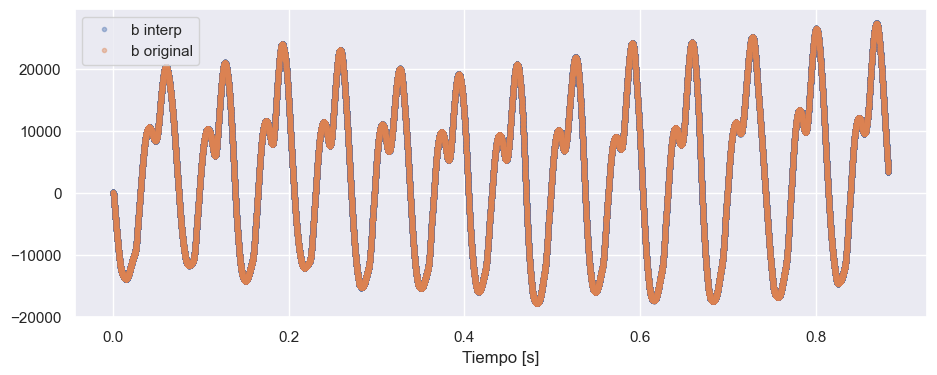

In [10]:
from scipy.interpolate import interp1d

p = files[1]['presion']
s = files[1]['sonido']

interp_func = interp1d(t_m, p)

b_interpolado = interp_func(np.linspace(0, t_m[-1],len(t) ))
plt.figure(figsize= (11,4))
plt.plot(t,b_interpolado, '.', label = "b interp", alpha = .4)
plt.plot(t_m, p, '.', label = "b original", alpha = .4)
plt.xlabel('Tiempo [s]')
plt.legend()
plt.show()

In [11]:
## NORMALIZO!!!! (primero normalizo, luego calculo el offset)
p = p/max(p)

#### Determino el offset $\beta = p + offset$ tal que los valores de $\beta$ sean negativos cuando el sonido es nulo

In [12]:

def plot1(offset):
    fig,ax = plt.subplots(figsize=(12,5))

    b = p + offset
    ax.plot(t_m,s, label = 'sonido', color = 'blue')
    ax.plot(t_m[b<0],s[b<0],'.', color = 'red')
    ax.plot()
    plt.legend(loc = 0)

    ax2=ax.twinx()
    ax2.tick_params(axis='both')
    ax2.plot(t_m,b, label = "presion")
    ax2.plot(t_m[b<0],b[b<0], color = 'red')
    ax2.axhline(y=0, color='black', linestyle='-')

    plt.legend(loc=1)
    plt.show()

#params
offset = widgets.FloatSlider(value=0.444 , min= 0.2 , max= 0.5, step= 1e-4, description='offset')

# linkeo el slider con los graficos
output1 = widgets.interactive_output(plot1, {'offset': offset})

# muestro los outputs#
display(offset, output1)


FloatSlider(value=0.444, description='offset', max=0.5, min=0.2, step=0.0001)

Output()

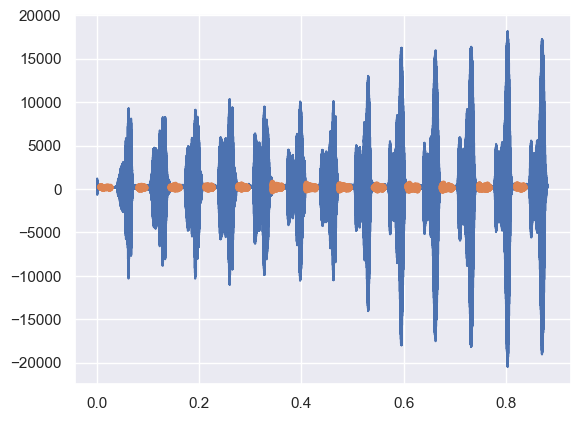

In [13]:
plt.plot(t_m[(p + 0.33)>0],s[(p + 0.33)>0])
plt.plot(t_m[(p + 0.33)<0],s[(p + 0.33)<0], '.')


Desviación estandar de la señal de sonido: 0.005802617103739156 


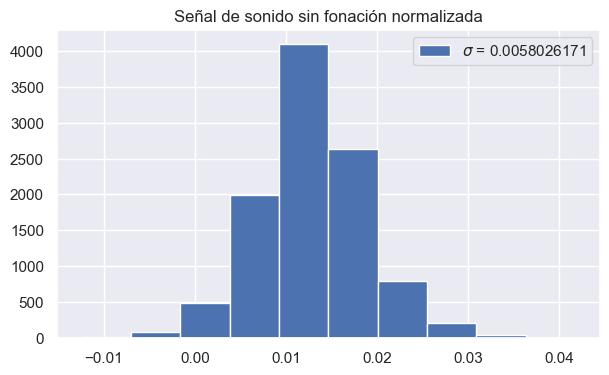

In [14]:
#sigma del sonido
sigma_s = np.std(s[(p + 0.33)<0]/max(s))

print(f'Desviación estandar de la señal de sonido: {sigma_s} ')
plt.figure(figsize=(7,4))
plt.title('Señal de sonido sin fonación normalizada')
plt.hist(s[(p + 0.33)<0]/max(s), label = r'$\sigma$ = ' + str(np.round(sigma_s,10) ), bins = 10)
plt.legend()
plt.show() 

In [15]:
# offset
offset = 0.33

### Con $\beta$ interpolado ahora corro la simulación.

#### Integro con ruido en $f_0$

In [16]:
#integro el ruido
ruido = np.random.normal(0, sigma_s, len(t))


colors = ['green','red','black','blue']
N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, f0 + ruido[j]*10, b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

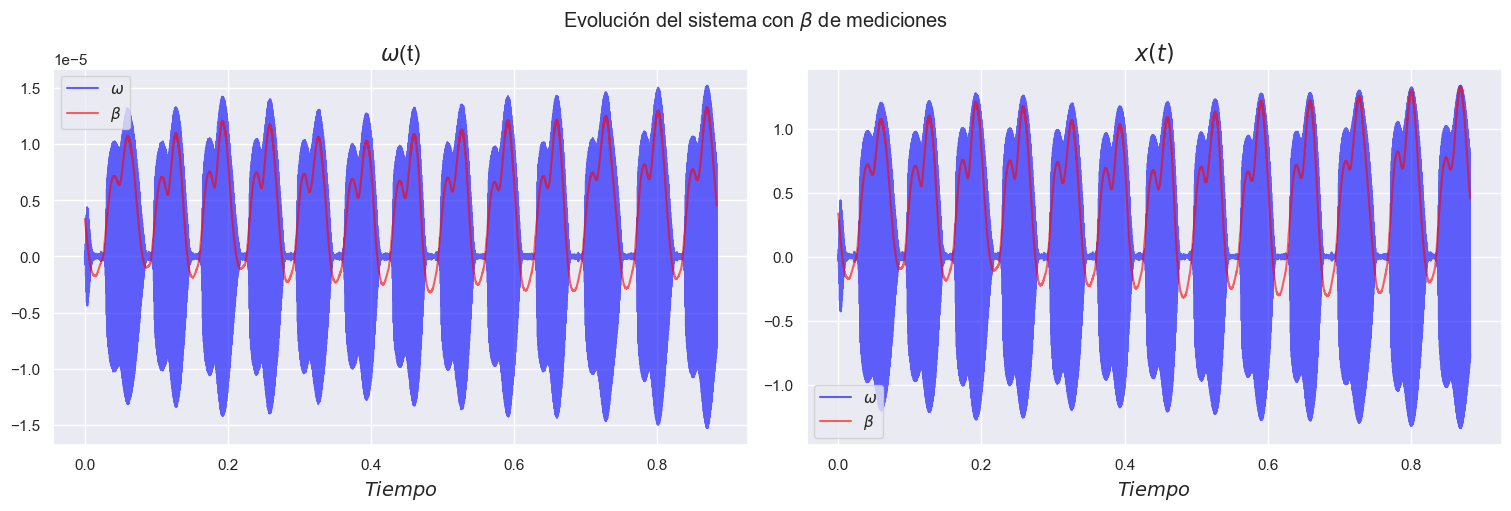

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True,
                                sharey=False)
#ploteo
ax1.plot(t,Xs[:,0][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax1.plot(t,b_*1e-5,alpha = .60, color=colors[1], label = r'$\beta$')
ax1.legend(loc=0)

ax2.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'$\omega$')
ax2.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
ax2. legend(loc=0)

ax1.set_xlabel('$Tiempo$', fontsize=14)
ax1.set_title(r'$\omega$(t)', fontsize=16)
ax2.set_xlabel('$Tiempo$', fontsize=14)
ax2.set_title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

El ruido que le generé a la señal se amplifica cuando integro. Voy a achicar el ruido para que me quede del orden del ruido del sonido.

comparo los datos de mediiciones con los de la simulación.
Para eso tengo que agarrar la cantidad de puntos de la medición

In [18]:
print(f'N de la simulacion: {len(t)} \n',f'N de los datos {len(t_m)} \n', f' Tomo de la simulación 1 dato cada {len(t)/len(t_m)}')

N de la simulacion: 779520 
 N de los datos 38976 
  Tomo de la simulación 1 dato cada 20.0


In [19]:
#t_ = [t[i] for i in range(len(t)) if i % 20 == 0]
t_s = np.array([])
s_s = np.array([])
b_s = np.array([])

s_sim = Xs[:,1]

for i in range(len(t)):
  if i % 20 == 0:
    t_s = np.append(t_s, t[i])
    s_s = np.append(s_s, s_sim[i])
    b_s = np.append(b_s, b_[i])
#t_s = np.array(t_s[:len(t_m)]) #esto lo hago por el desfasaje de los dts!!! 
#s_s = np.array(s_s[:len(t_m)])

s_m = s/max(s) * max(s_s) # escaleo para que quede proporcional a las simulaciones
print(len(t_s), len(s_s), len(t_m), len(s_m))

38976 38976 38976 38976


En limpio las variables me quedaron:
t_s, t_m y s_s, s_m

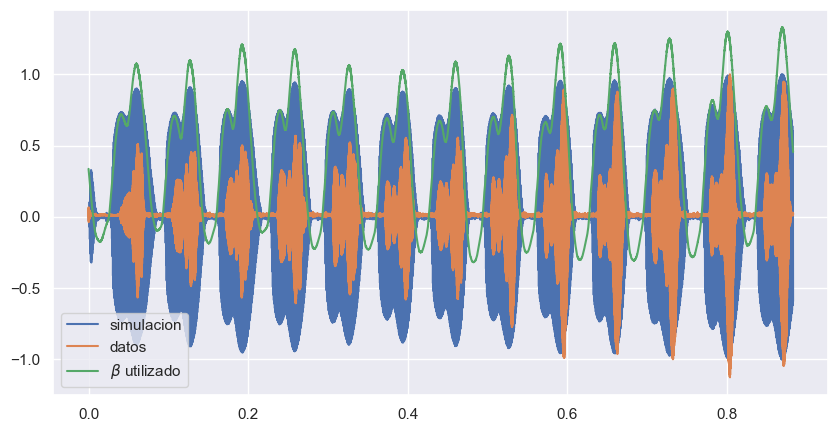

In [20]:


plt.figure(figsize=(10,5))
plt.plot(t_s,s_s/max(s_s), label = 'simulacion')
plt.plot(t_m,s_m/max(s_m), label = 'datos')
#plt.plot(t_m, p/max(p)*max(s_s), label = 'beta')
plt.plot(t_m,b_s, label = r'$\beta$ utilizado')
#plt.plot(t_m,s_m-s_s,alpha = 0.4, label = 'diferencia') #sospecho que la diferencia es muy grande 
plt.legend()



Estudiar la envolvente en otro momento

GUARDO LOS ARCHIVOS

In [54]:
# guardo en un archivo la simulación}

wavfile.write("sonido-presion/simulacion_segmento_1.wav", frec_m, s_s.astype(np.float32))
wavfile.write("sonido-presion/beta_segmento_1.wav", frec_m, b_s.astype(np.float32)) #guardo el beta que use en la simulacion para comparar!!

# Segmento 1: $\delta$ prendido y apagado con el treshold viejo

In [61]:
#delta 
fs, delta = wavfile.read('sonido-presion/delta_segmento_1_viejo.wav')

#interpolo 

p = files[1]['presion']
s = files[1]['sonido']

interp_func = interp1d(t_m, delta)

delta_interp = interp_func(np.linspace(0, t_m[-1],len(t) ))


In [73]:
#delta


N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, delta_interp[j] *4 + ruido[j], b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

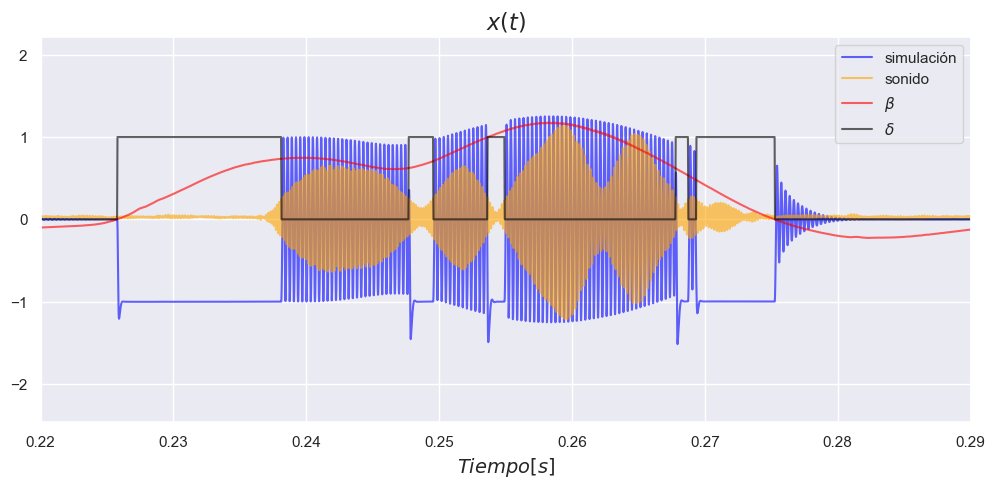

In [74]:
plt.figure( figsize=(12,5))
#ploteo

plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.22,0.29)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

In [75]:
#ahora lo mismo pero uso delta que se disipa más lento

#delta

k = 4 # cambiio este parámetro para subir la frecuencia de las oscilaciones
N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, delta_interp[j]* 1.25 + ruido[j], b_[j]] # como cambié k, los valores de delta tiene que ser mayores
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

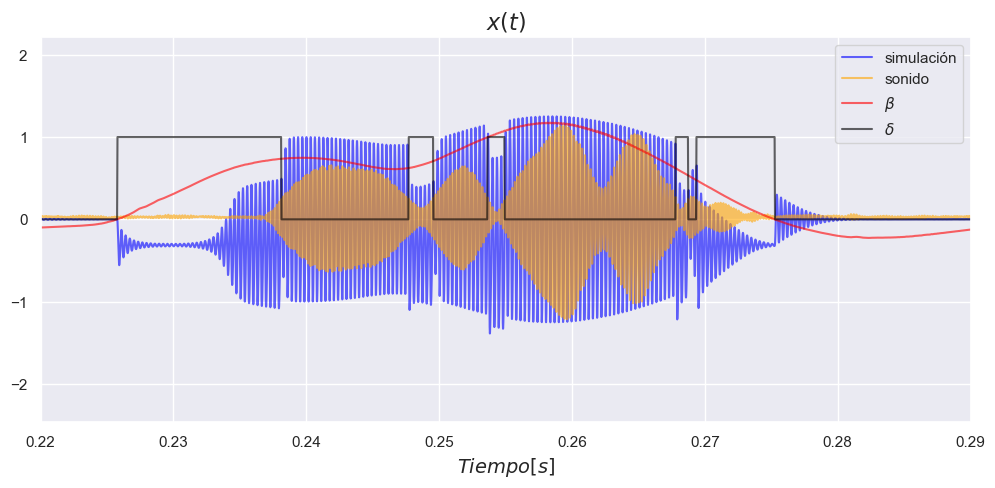

In [76]:
plt.figure( figsize=(12,5))
#ploteo

plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.22,0.29)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

# Segmento 1: $\delta$ prendido y apagado con el treshold viejo

In [77]:
#delta 
fs, delta = wavfile.read('sonido-presion/delta_segmento_1.wav')

#interpolo 

p = files[1]['presion']
s = files[1]['sonido']

interp_func = interp1d(t_m, delta)

delta_interp = interp_func(np.linspace(0, t_m[-1],len(t) ))


In [78]:
#delta


N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, delta_interp[j]*4 + ruido[j], b_[j]]
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

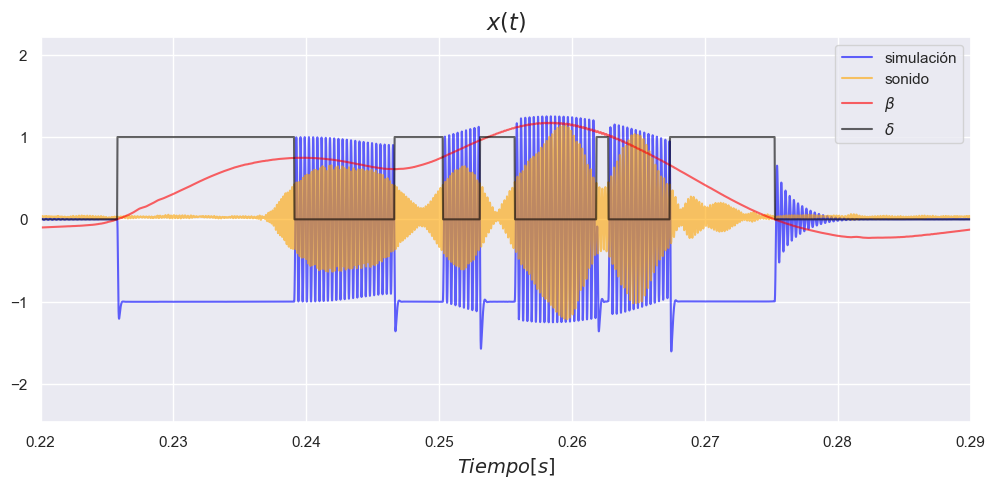

In [79]:
plt.figure( figsize=(12,5))
#ploteo

plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0.22,0.29)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

In [83]:
#ahora lo mismo pero uso delta que se disipa más lento

#delta

k = 4 # cambiio este parámetro para subir la frecuencia de las oscilaciones
N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) + offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, delta_interp[j]* 1.5 + ruido[j], b_[j]] # como cambié k, los valores de delta tiene que ser mayores
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

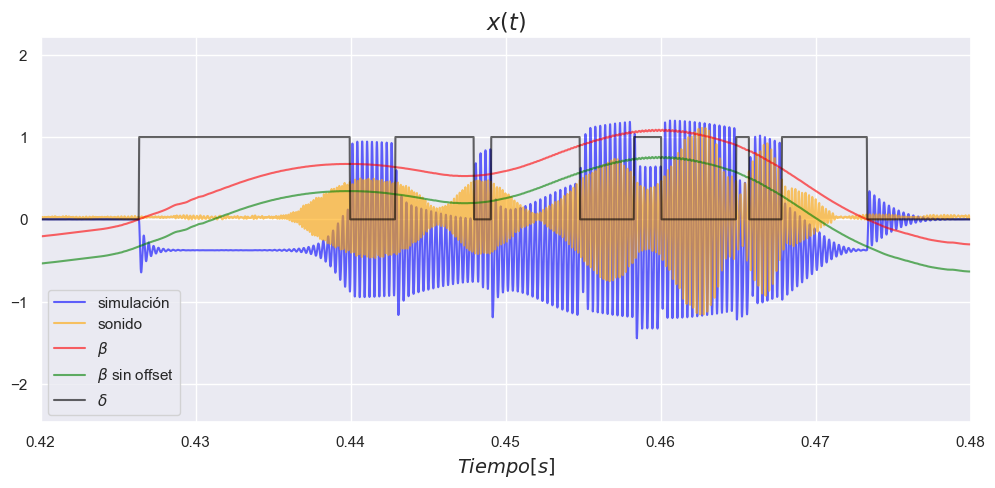

In [87]:
plt.figure( figsize=(12,5))
#ploteo

plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2,alpha = .60, color='orange', label = r'sonido')
plt.plot(t,b_,alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t, (b_interpolado/max(b_interpolado)),alpha = .60, color='green', label = r'$\beta$ sin offset')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
#plt.xlim(0.22,0.29)
plt.xlim(0.42,0.48)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")

In [88]:
#ahora lo mismo pero uso delta que se disipa más lento

#delta

k = 4 # cambiio este parámetro para subir la frecuencia de las oscilaciones
N_i = len(t)
b_ = (b_interpolado/max(b_interpolado)) #+ offset #NORMALIZO
Xs = np.zeros((N_i + 1, 2))
Xs[0] = X0
# Integración: le agrego el ruido a f0 para 
for j in range(N_i):
    params = [k, c, delta_interp[j]* 1.5 + ruido[j], b_[j]] # como cambié k, los valores de delta tiene que ser mayores
    Xs[j + 1] = paso_RK(Xs[j], f, t[j], dt, params, 4)
    


Text(0.5, 0.98, 'Evolución del sistema con $\\beta$ de mediciones')

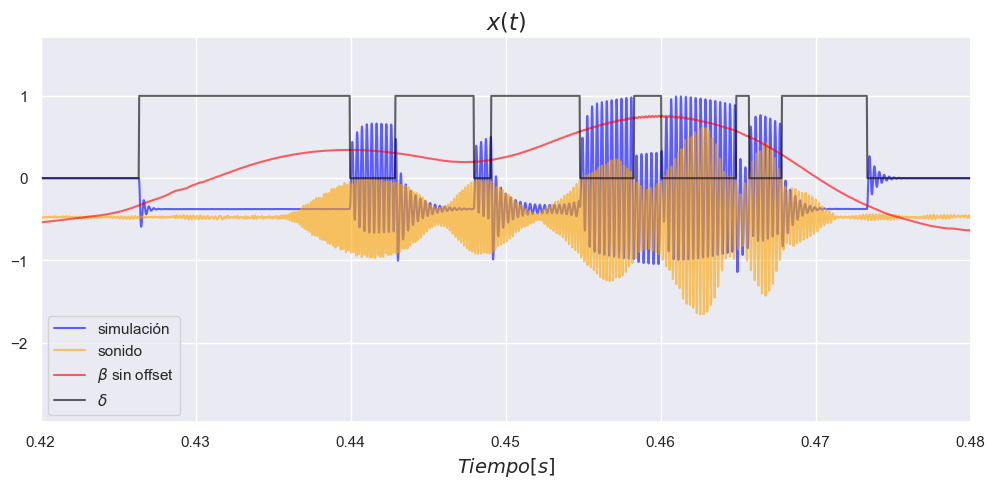

In [89]:
plt.figure( figsize=(12,5))
#ploteo

plt.plot(t,Xs[:,1][:-1],alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t_m,s_m/max(s_m) * 2 - 0.5,alpha = .60, color='orange', label = r'sonido')
plt.plot(t, (b_interpolado/max(b_interpolado)),alpha = .60, color=colors[1], label = r'$\beta$ sin offset')
plt.plot(t,delta_interp,alpha = .60, color=colors[2], label = r'$\delta$')
plt.legend(loc=0)
#plt.xlim(0.22,0.29)
plt.xlim(0.42,0.48)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$x(t)$', fontsize=16)


fig.suptitle(r"Evolución del sistema con $\beta$ de mediciones")